In [4]:
%pip install -q matplotlib
%pip install -q numpy
%pip install -q torch
%pip install -q tensorflow
%pip insatll -q tensorflow.keras
import matplotlib.pyplot as plt
import numpy as np
# 下載 Gridworld.py 及 GridBoard.py (-q 是設為安靜模式)
# !curl -O https://github.com/DeepReinforcementLearning/DeepReinforcementLearningInAction/raw/master/Errata/Gridworld.py
# !curl -O https://github.com/DeepReinforcementLearning/DeepReinforcementLearningInAction/raw/master/Errata/GridBoard.py



Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


  You can safely remove it manually.
  You can safely remove it manually.


Note: you may need to restart the kernel to use updated packages.


ERROR: unknown command "insatll" - maybe you meant "install"



In [2]:
from Gridworld_model import *
game = Gridworld(size=4, mode='static')
game.display()

array([['+', '-', ' ', 'P'],
       [' ', 'W', ' ', ' '],
       [' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [3]:
action_set = {
	0: 'u', #『0』代表『向上』
	1: 'd', #『1』代表『向下』
	2: 'l', #『2』代表『向左』
	3: 'r' #『3』代表『向右』
}

# 網路參數設定

In [9]:
"""keras_dqn.py
=================================
Minimal, self-contained DQN with Experience Replay using Keras for the 4×4 Gridworld.

Usage (static mode example) ───────────────────────────────────────────
$ python keras_dqn.py --mode static --episodes 5000

Required file: Gridworld_model.py (from DRL-in-Action)
-----------------------------------------------------------------------
"""
import argparse, random
from collections import deque, namedtuple

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras import losses as loss_module
from Gridworld_model import Gridworld
import matplotlib.pyplot as plt

# ───────────────────────────── replay buffer ────────────────────────── #
Transition = namedtuple('T', ['s', 'a', 'r', 's1', 'done'])
class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buf = deque(maxlen=capacity)
    def add(self, *args):
        self.buf.append(Transition(*args))
    def sample(self, batch_size):
        batch = random.sample(self.buf, batch_size)
        t = Transition(*zip(*batch))
        return (
            np.stack(t.s),               # (B, 64)
            np.array(t.a,   dtype=np.int32).reshape(-1,1),
            np.array(t.r,   dtype=np.float32).reshape(-1,1),
            np.stack(t.s1),              # (B, 64)
            np.array(t.done, dtype=np.float32).reshape(-1,1),
        )
    def __len__(self):
        return len(self.buf)

# ─────────────────────────────── network ────────────────────────────── #
def build_model(input_dim=64, hidden1=150, hidden2=100, output_dim=4):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(hidden1, activation='relu'),
        layers.Dense(hidden2, activation='relu'),
        layers.Dense(output_dim)
    ])
    return model

Ep    0 | ε=0.985 | last loss=2.7239
Ep  100 | ε=0.533 | last loss=0.3419
Ep  200 | ε=0.322 | last loss=0.4406
Ep  300 | ε=0.155 | last loss=0.0362
Ep  400 | ε=0.100 | last loss=0.0853
Ep  500 | ε=0.100 | last loss=0.0466
Ep  600 | ε=0.100 | last loss=0.0513
Ep  700 | ε=0.100 | last loss=0.0419
Ep  800 | ε=0.100 | last loss=0.0343
Ep  900 | ε=0.100 | last loss=0.0550
Ep 1000 | ε=0.100 | last loss=0.1478
Ep 1100 | ε=0.100 | last loss=0.1248
Ep 1200 | ε=0.100 | last loss=0.0839
Ep 1300 | ε=0.100 | last loss=0.0485
Ep 1400 | ε=0.100 | last loss=0.2048
Ep 1500 | ε=0.100 | last loss=0.1837
Ep 1600 | ε=0.100 | last loss=0.0269
Ep 1700 | ε=0.100 | last loss=0.0614
Ep 1800 | ε=0.100 | last loss=0.0357
Ep 1900 | ε=0.100 | last loss=0.1266
Ep 2000 | ε=0.100 | last loss=0.0532
Ep 2100 | ε=0.100 | last loss=0.0600
Ep 2200 | ε=0.100 | last loss=0.0345
Ep 2300 | ε=0.100 | last loss=0.0346
Ep 2400 | ε=0.100 | last loss=0.0333
Ep 2500 | ε=0.100 | last loss=0.0358
Ep 2600 | ε=0.100 | last loss=0.0112
E

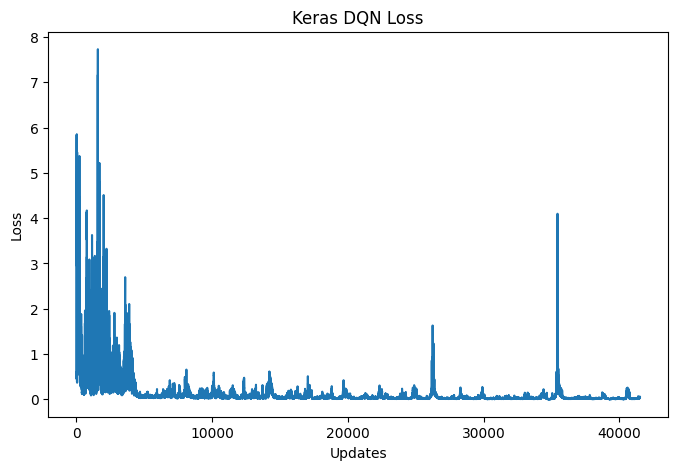

In [10]:
# ─────────────────────────────── train ─────────────────────────────── #
def train(mode='static', episodes=5000, batch_size=64, gamma=0.99,
          lr=1e-3, epsilon_start=1.0, epsilon_end=0.1, eps_decay_steps=5000):
    # 初始化
    model = build_model()
    optimizer = optimizers.Adam(learning_rate=lr)
    loss_fn = loss_module.MeanSquaredError()
    buffer = ReplayBuffer(capacity=10000)
    epsilon = epsilon_start
    eps_decay = (epsilon_start - epsilon_end) / eps_decay_steps
    action_set = {0:'u', 1:'d', 2:'l', 3:'r'}
    loss_history = []

    for ep in range(episodes):
        env = Gridworld(size=4, mode=mode)
        state = env.board.render_np().reshape(64) + np.random.rand(64)/10.0
        done = False
        while not done:
            # ε-greedy
            if random.random() < epsilon:
                a_idx = random.randint(0,3)
            else:
                qvals = model.predict(state.reshape(1,64), verbose=0)
                a_idx = int(np.argmax(qvals[0]))
            env.makeMove(action_set[a_idx])
            next_state = env.board.render_np().reshape(64) + np.random.rand(64)/10.0
            reward = env.reward()
            done = abs(reward) == 10

            # 存回放緩衝區
            buffer.add(state, a_idx, reward, next_state, done)

            # 學習
            if len(buffer) >= batch_size:
                s, a, r, s1, d = buffer.sample(batch_size)
                # 計算 TD target
                q_next = model.predict(s1, verbose=0)
                max_q_next = np.max(q_next, axis=1, keepdims=True)
                y = r + (1 - d) * gamma * max_q_next

                with tf.GradientTape() as tape:
                    q_pred_all = model(tf.convert_to_tensor(s, dtype=tf.float32))
                    # gather Q(s,a)
                    idx = np.concatenate([np.arange(batch_size).reshape(-1,1), a], axis=1)
                    q_pred = tf.gather_nd(q_pred_all, idx)
                    q_pred = tf.expand_dims(q_pred, axis=1)
                    loss = loss_fn(y, q_pred)
                grads = tape.gradient(loss, model.trainable_variables)
                optimizer.apply_gradients(zip(grads, model.trainable_variables))
                loss_history.append(float(loss))

            state = next_state
            # ε decay
            if epsilon > epsilon_end:
                epsilon -= eps_decay

        # Logging
        if ep % 100 == 0 and loss_history:
            print(f"Ep {ep:4d} | ε={epsilon:.3f} | last loss={loss_history[-1]:.4f}")

    # 畫 Loss 曲線
    if loss_history:
        plt.figure(figsize=(8,5))
        plt.plot(loss_history)
        plt.title('Keras DQN Loss')
        plt.xlabel('Updates')
        plt.ylabel('Loss')
        plt.show()

if __name__ == '__main__':
    p = argparse.ArgumentParser()
    p.add_argument('--mode', choices=['static','player','random'], default='static')
    p.add_argument('--episodes', type=int, default=5000)
    args, _ = p.parse_known_args()
    train(mode=args.mode, episodes=args.episodes)